In [1]:
!python3 -m venv venv
!venv/bin/python -m pip install ipykernel
!venv/bin/python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"
%pip install datasets wandb transformers matplotlib torch-tb-profiler

Installed kernelspec myenv in /root/.local/share/jupyter/kernels/myenv
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.optim as optim
import numpy as np
import wandb
from tqdm import tqdm
from torch.optim import AdamW
torch.cuda.manual_seed_all(423)

/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
project_name = "hpml-hw2-llm2"

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
from transformers import DistilBertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

## C1

In [7]:
import wandb

wandb.init(project="hpml-hw2-llm", name=f"bs32_lr1e-4", group = "Warm Up Experiment")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ykmao1515 (kaimao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:


config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  for batch in tqdm(train_loader):
      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
           "train/acc": avg_accuracy,
           "test/acc": accuracy})
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variabl

Epoch 1/5, Loss: 0.3095, Train Accuracy: 0.8674, Test Accuracy: 0.8892


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.87it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 2/5, Loss: 0.1738, Train Accuracy: 0.9341, Test Accuracy: 0.8861


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.79it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 3/5, Loss: 0.0891, Train Accuracy: 0.9681, Test Accuracy: 0.8826


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.84it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 4/5, Loss: 0.0568, Train Accuracy: 0.9804, Test Accuracy: 0.8705


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:44<00:00, 17.74it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 5/5, Loss: 0.0385, Train Accuracy: 0.9876, Test Accuracy: 0.8718


In [ ]:
wandb.finish()

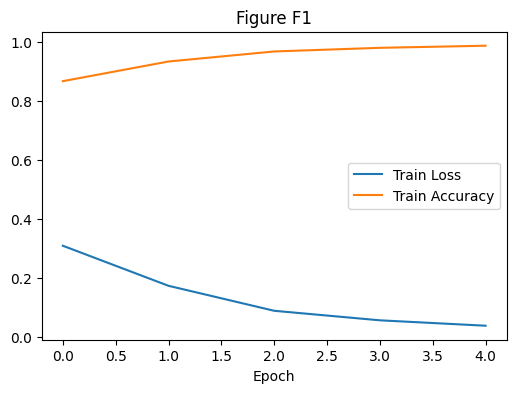

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Value')
plt.title('Figure F1')
plt.legend()
plt.show()

In [ ]:
print(train_loss, train_accuracy, test_accuracy)

### Table T1

| Epoch | Train Loss | Train Acc | Test Acc |
|-------|------------|-----------|----------|
|1|0.0317|0.9902|0.8764|
|2|0.0246|0.9920|0.8895|
|3|0.0211|0.9932|0.8765|
|4|0.0178|0.9940|0.8791|
|5|0.0173|0.9947|0.8740|


# C2

In [13]:
wandb.init(project=project_name, name=f"bs32_lr1e-4", group = "Baseline Timing")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test/acc,█▇▆▁▁
train/acc,▁▅▇██
test/acc,0.87176
train/acc,0.98756


In [14]:
import time

config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []
data_loading_time_arr = []
compute_time_arr = []
epoch_time_arr = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  data_loading_time = 0
  training_compute_time = 0
  total_epoch_time = 0
  start_data_loading = time.time()
  start_epoch_time = time.time()
  for batch in train_loader:
      torch.cuda.synchronize()
      end = time.time()
      data_loading_time +=  end - start_data_loading

      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      start_compute = time.time()
      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      torch.cuda.synchronize()
      end = time.time()
      training_compute_time += end - start_compute

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

      start_data_loading = time.time()

  end = time.time()
  total_epoch_time = end - start_epoch_time

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
            "train/acc": avg_accuracy,
            "test/acc": accuracy,
             "data-loading time": data_loading_time,
             "compute time": training_compute_time,
             "total epoch time": total_epoch_time})

  data_loading_time_arr.append(data_loading_time)
  compute_time_arr.append(training_compute_time)
  epoch_time_arr.append(total_epoch_time)
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
          compute time: {training_compute_time} total epoch time: {total_epoch_time}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Epoch 1/5, Loss: 0.3083, Train Accuracy: 0.8684, Test Accuracy: 0.9026, data_loading time: 1.1752495765686035           compute time: 41.5190954208374 total epoch time: 43.29253888130188


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1707, Train Accuracy: 0.9360, Test Accuracy: 0.8947, data_loading time: 1.1852033138275146           compute time: 41.82760190963745 total epoch time: 43.6026086807251


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0853, Train Accuracy: 0.9709, Test Accuracy: 0.8808, data_loading time: 1.141286849975586           compute time: 41.886305809020996 total epoch time: 43.60154056549072


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0536, Train Accuracy: 0.9812, Test Accuracy: 0.8782, data_loading time: 1.1710238456726074           compute time: 41.90685701370239 total epoch time: 43.64450740814209


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0361, Train Accuracy: 0.9872, Test Accuracy: 0.8604, data_loading time: 1.1747565269470215           compute time: 41.91785144805908 total epoch time: 43.67530798912048


In [15]:
wandb.finish()

compute time,▁▆▇██
data-loading time,▆█▁▆▆
test/acc,█▇▄▄▁
total epoch time,▁▇▇▇█
train/acc,▁▅▇██
compute time,41.91785
data-loading time,1.17476
test/acc,0.86036
total epoch time,43.67531
train/acc,0.9872


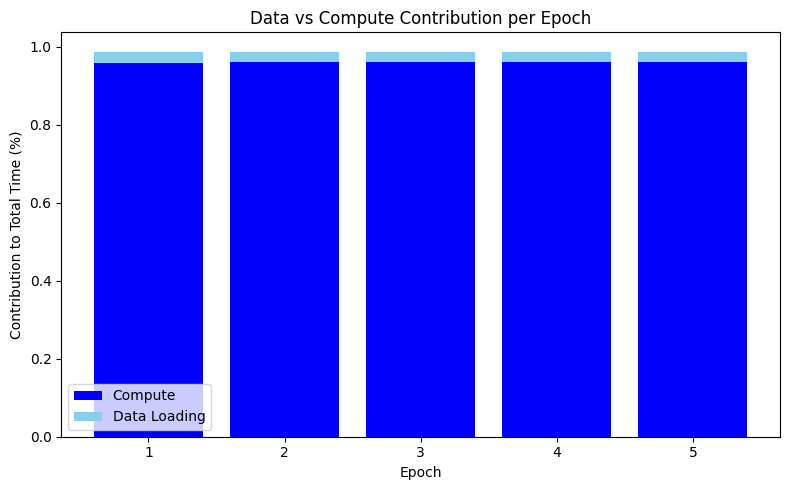

In [23]:
plt.figure(figsize=(8, 5))

epochs = [1, 2, 3, 4, 5]
# Stack bars
plt.bar(epochs, np.array(compute_time_arr)/np.array(epoch_time_arr), label='Compute', color='blue')
plt.bar(epochs, np.array(data_loading_time_arr)/np.array(epoch_time_arr), bottom=np.array(compute_time_arr)/np.array(epoch_time_arr), label='Data Loading', color='skyblue')

# 🧾 Annotate total time on top of each bar
# for i in range(len(epochs)):
#     plt.text(epochs[i], epoch_time_arr[i] + 0.3, f"{epoch_time_arr[i]:.1f}s",
#              ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Epoch')
plt.ylabel('Contribution to Total Time (%)')
plt.title('Data vs Compute Contribution per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print(data_loading_time_arr, compute_time_arr, epoch_time_arr)

[1.1752495765686035, 1.1852033138275146, 1.141286849975586, 1.1710238456726074, 1.1747565269470215] [41.5190954208374, 41.82760190963745, 41.886305809020996, 41.90685701370239, 41.91785144805908] [43.29253888130188, 43.6026086807251, 43.60154056549072, 43.64450740814209, 43.67530798912048]


# C3

In [25]:
avg_epoch_time_arr = []
avg_data_time_arr = []

def train():
  with wandb.init(
      group="DataLoader Performance",
      config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config
      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_num_workers{config.num_workers}"
      
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
          
      avg_epoch_time_arr.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_data_time_arr.append(sum(data_loading_time_arr)/len(data_loading_time_arr))
      

In [26]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'num_workers': {'values': [0, 2, 4, 8]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train, count=4)

Create sweep with ID: 3p7k5crm
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm2/sweeps/3p7k5crm


wandb: Agent Starting Run: gicy0i6y with config:
wandb: 	num_workers: 0
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(0) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3074, Train Accuracy: 0.8692, Test Accuracy: 0.8851, data_loading time: 3.2625324726104736                 compute time: 41.586782455444336 total epoch time: 45.099496364593506
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1697, Train Accuracy: 0.9364, Test Accuracy: 0.8996, data_loading time: 3.2400829792022705                 compute time: 41.91038393974304 total epoch time: 45.39018106460571
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0900, Train Accuracy: 0.9681, Test Accuracy: 0.8803, data_loading time: 3.2441353797912598                 compute time: 41.98482608795166 total epoch time: 45.45478272438049
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0553, Train Accuracy: 0.9821, Test Accuracy: 0.8635, data_loading time: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0458, Train Accuracy: 0.9848, Test Accuracy: 0.8676, data_loading time: 3.2329676151275635                 compute time: 41.983314514160156 total epoch time: 45.4404833316803
-------------------------------------------------------------------------------


compute time,▁▇███
data-loading time,█▄▄▁▂
test/acc,▅█▄▁▂
total epoch time,▁▇███
train/acc,▁▅▇██
compute time,41.98331
data-loading time,3.23297
test/acc,0.86756
total epoch time,45.44048
train/acc,0.98484


wandb: Agent Starting Run: xp3xsqh3 with config:
wandb: 	num_workers: 2
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3045, Train Accuracy: 0.8700, Test Accuracy: 0.8980, data_loading time: 1.43206787109375                 compute time: 42.13941979408264 total epoch time: 43.948729515075684
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1615, Train Accuracy: 0.9410, Test Accuracy: 0.8802, data_loading time: 1.2880611419677734                 compute time: 42.132593870162964 total epoch time: 43.774178981781006
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0839, Train Accuracy: 0.9710, Test Accuracy: 0.8930, data_loading time: 1.3085389137268066                 compute time: 42.14713144302368 total epoch time: 43.813663482666016
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0534, Train Accuracy: 0.9821, Test Accuracy: 0.8836, data_loading time: 1.2157397270202637                 compute time: 42.06484770774841 total epoch time: 43.611894369125366
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0481, Train Accuracy: 0.9845, Test Accuracy: 0.8762, data_loading time: 1.2825431823730469                 compute time: 42.0499529838562 total epoch time: 43.64691138267517
-------------------------------------------------------------------------------


compute time,▇▇█▂▁
data-loading time,█▃▄▁▃
test/acc,█▂▆▃▁
total epoch time,█▄▅▁▂
train/acc,▁▅▇██
compute time,42.04995
data-loading time,1.28254
test/acc,0.87616
total epoch time,43.64691
train/acc,0.98452


wandb: Agent Starting Run: fv72fcpn with config:
wandb: 	num_workers: 4
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(4) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3024, Train Accuracy: 0.8732, Test Accuracy: 0.9009, data_loading time: 1.2394201755523682                 compute time: 41.9440553188324 total epoch time: 43.53215169906616
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1699, Train Accuracy: 0.9370, Test Accuracy: 0.8876, data_loading time: 1.2744231224060059                 compute time: 42.048025608062744 total epoch time: 43.652538776397705
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0871, Train Accuracy: 0.9709, Test Accuracy: 0.8801, data_loading time: 1.558837652206421                 compute time: 42.26429533958435 total epoch time: 44.21101760864258
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0548, Train Accuracy: 0.9808, Test Accuracy: 0.8703, data_loading time: 1.8174281120300293                 compute time: 42.46608066558838 total epoch time: 44.67887258529663
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0444, Train Accuracy: 0.9852, Test Accuracy: 0.8741, data_loading time: 1.2845323085784912                 compute time: 42.04469895362854 total epoch time: 43.68988227844238
-------------------------------------------------------------------------------


compute time,▁▂▅█▂
data-loading time,▁▁▅█▂
test/acc,█▅▃▁▂
total epoch time,▁▂▅█▂
train/acc,▁▅▇██
compute time,42.0447
data-loading time,1.28453
test/acc,0.87412
total epoch time,43.68988
train/acc,0.98524


wandb: Agent Starting Run: giqclgi7 with config:
wandb: 	num_workers: 8
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(8) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3091, Train Accuracy: 0.8666, Test Accuracy: 0.8940, data_loading time: 1.3921043872833252                 compute time: 41.97293710708618 total epoch time: 43.72316646575928
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1647, Train Accuracy: 0.9394, Test Accuracy: 0.8846, data_loading time: 1.4255974292755127                 compute time: 42.07152271270752 total epoch time: 43.8545024394989
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0873, Train Accuracy: 0.9694, Test Accuracy: 0.8858, data_loading time: 1.4303972721099854                 compute time: 42.07430100440979 total epoch time: 43.85521960258484
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0513, Train Accuracy: 0.9830, Test Accuracy: 0.8728, data_loading time: 1.4163362979888916                 compute time: 42.061704874038696 total epoch time: 43.83255934715271
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0443, Train Accuracy: 0.9860, Test Accuracy: 0.8550, data_loading time: 1.4148354530334473                 compute time: 42.051302433013916 total epoch time: 43.81689810752869
-------------------------------------------------------------------------------


compute time,▁██▇▆
data-loading time,▁▇█▅▅
test/acc,█▆▇▄▁
total epoch time,▁██▇▆
train/acc,▁▅▇██
compute time,42.0513
data-loading time,1.41484
test/acc,0.855
total epoch time,43.8169
train/acc,0.98604


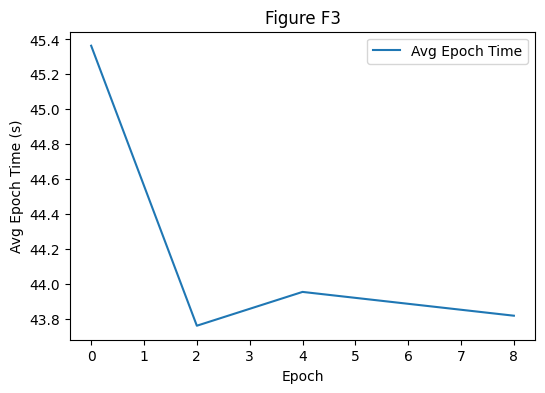

In [27]:
plt.figure(figsize=(6, 4))

num_workers = [0, 2, 4, 8]
plt.plot(num_workers, avg_epoch_time_arr, label='Avg Epoch Time')
plt.xlabel('Epoch')
plt.ylabel('Avg Epoch Time (s)')
plt.title('Figure F3')
plt.legend()
plt.show()

In [28]:
print(avg_epoch_time_arr, avg_data_time_arr)

[45.36399168968201, 43.75907554626465, 43.95289258956909, 43.81646919250488] [3.2410942554473876, 1.3053901672363282, 1.4349282741546632, 1.4158541679382324]


# C4

In [7]:
import torch.profiler as profiler

for num_workers in [1,2]:
    wandb.init(project="hpml-hw2-llm3", name=f"bs32_lr1e-4num_works{num_workers}", group = "PyTorch Profiler")

    wandb.config.update({
        "model_name": "distilbert-base-uncased",
        "max_len": 256,
        "batch_size": 32,
        "lr": 1e-4,
        "optimizer": "AdamW",
        "num_workers": num_workers,
        "epochs": 1,
        "compile_mode": False
    })
    config = wandb.config
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=config.lr)
    
    train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
    test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
    print(f"config num:{config.num_workers}")
    
    train_loss = []
    train_accuracy = []
    test_accuracy = []
    
    with profiler.profile(
        activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA],
        # on_trace_ready=torch.profiler.tensorboard_trace_handler("./profiler_logs"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            total_correct = 0
            total_samples = 0
            for batch in tqdm(train_loader):
                optimizer.zero_grad()
    
                with profiler.record_function("data_loading"):
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                        "labels": batch["labels"].to(device),
                    }
    
                with profiler.record_function("forward"):
                    outputs = model(**inputs)
    
                with profiler.record_function("backward"):
                    loss = outputs.loss
                    loss.backward()
    
                with profiler.record_function("optimizer"):
                    optimizer.step()
    
                logits = outputs.logits
                preds = torch.argmax(logits, dim = 1)
                labels = batch["labels"].to(device)
                correct = (preds == labels).sum().item()
                total_correct += correct
                total_samples += len(labels)
                total_loss += loss.item()
    
            avg_loss = total_loss / len(train_loader)
            avg_accuracy = total_correct / total_samples
            train_loss.append(avg_loss)
            train_accuracy.append(avg_accuracy)
    
            model.eval()
            correct = 0
            total = 0
    
            with torch.no_grad():
                for batch in test_loader:
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                    }
                    labels = batch["labels"].to(device)
    
                    logits = model(**inputs).logits
                    preds = torch.argmax(logits, dim=1)
    
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
    
            accuracy = correct / total
            test_accuracy.append(accuracy)
            print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")

            prof.step()
    print("\n===== CPU Profiling =====")

    # print(prof.is_active(), prof.profiler)
    torch.cuda.synchronize()
    print(prof.key_averages().table(
        sort_by="self_cpu_time_total",  # or "cpu_time_total"
        row_limit=20
    ))
    
    # ✅ Print GPU-focused results
    print("\n===== GPU Profiling =====")
    print(prof.key_averages().table(
        sort_by="self_cuda_time_total",  # or "cuda_time_total"
        row_limit=20
    ))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config num:1


100%|██████████| 782/782 [00:47<00:00, 16.48it/s]


Epoch 1/1, Loss: 0.3067, Train Accuracy: 0.8695, Test Accuracy: 0.9015

===== CPU Profiling =====
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamSynchronize        28.90%       22.115s        28.90%       22.115s       2.357ms       0.000u

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config num:2


100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Epoch 1/1, Loss: 0.3149, Train Accuracy: 0.8660, Test Accuracy: 0.8974

===== CPU Profiling =====
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamSynchronize        32.49%       25.035s        32.49%       25.035s       2.668ms       0.000u

In [9]:
Epoch 1/1, Loss: 0.3067, Train Accuracy: 0.8695, Test Accuracy: 0.9015

===== CPU Profiling =====
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamSynchronize        28.90%       22.115s        28.90%       22.115s       2.357ms       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B          9384  
                                               backward        21.53%       16.479s        21.75%       16.647s      21.287ms       0.000us         0.00%     591.550us       0.756us     -73.31 KB     -73.28 KB   -1638.43 GB   -1638.27 GB           782  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...         7.29%        5.579s         7.34%        5.617s       3.587ms       0.000us         0.00%       0.000us       0.000us     195.69 MB     195.50 MB           0 B           0 B          1566  
                                                forward         4.79%        3.669s        12.61%        9.647s      12.336ms       0.000us         0.00%       15.294s      19.557ms      73.31 KB      -3.05 KB    1836.28 GB    -381.56 GB           782  
                              Optimizer.step#AdamW.step         4.69%        3.586s         7.71%        5.903s       7.548ms       0.000us         0.00%        2.779s       3.554ms         416 B      -3.05 KB     510.83 MB    -195.05 GB           782  
                                       cudaLaunchKernel         2.76%        2.116s         2.80%        2.145s       8.673us       0.000us         0.00%     798.937us       0.003us           0 B           0 B           0 B           0 B        247301  
                                            aten::addmm         2.66%        2.035s         3.68%        2.814s      47.355us       26.199s        46.90%       26.201s     440.854us           0 B           0 B    1977.68 GB    1977.68 GB         59432  
                                               aten::mm         2.58%        1.973s         3.70%        2.829s      47.609us       16.342s        29.25%       16.342s     274.969us           0 B           0 B    1117.21 GB    1117.21 GB         59432  
                                        aten::transpose         1.30%     991.595ms         1.78%        1.359s       4.324us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        314364  
                                              aten::sum         1.29%     985.262ms         1.93%        1.476s      40.154us     687.082ms         1.23%     688.771ms      18.740us           0 B           0 B       2.41 GB       2.41 GB         36754  
                                         cuLaunchKernel         1.23%     939.936ms         1.23%     943.680ms       7.992us       0.000us         0.00%     463.166us       0.004us           0 B           0 B           0 B           0 B        118077  
                                            aten::empty         1.17%     896.615ms         1.17%     896.615ms       5.209us       0.000us         0.00%       0.000us       0.000us     469.87 KB     469.87 KB    1646.27 GB    1646.27 GB        172139  
                                        cudaMemsetAsync         0.98%     750.617ms         0.98%     750.617ms       5.189us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        144667  
    autograd::engine::evaluate_function: AddmmBackward0         0.92%     701.966ms         7.92%        6.064s     204.069us       0.000us         0.00%       16.950s     570.402us           0 B           0 B    -439.20 GB   -1556.54 GB         29716  
                                             aten::view         0.88%     670.713ms         0.88%     670.713ms       2.171us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        308890  
                                    aten::empty_strided         0.81%     622.397ms         0.81%     622.397ms       5.928us       0.000us         0.00%       0.000us       0.000us           0 B           0 B     372.71 GB     372.71 GB        104996  
     autograd::engine::evaluate_function: ViewBackward0         0.76%     581.743ms         2.12%        1.623s      21.394us       0.000us         0.00%     360.275ms       4.750us           0 B           0 B    -439.45 GB    -439.45 GB         75854  
                                                aten::t         0.75%     573.036ms         1.77%        1.357s       7.609us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        178296  
                                         AddmmBackward0         0.65%     495.818ms         5.32%        4.070s     136.957us       0.000us         0.00%       16.342s     549.938us           0 B           0 B    1117.21 GB           0 B         29716  
                                           aten::linear         0.64%     489.399ms         5.33%        4.080s      68.647us       0.000us         0.00%       26.201s     440.854us           0 B           0 B    1977.68 GB     -25.00 MB         59432  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 76.528s
Self CUDA time total: 55.861s


===== GPU Profiling =====
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::addmm         2.66%        2.035s         3.68%        2.814s      47.355us       26.199s        46.90%       26.201s     440.854us           0 B           0 B    1977.68 GB    1977.68 GB         59432  
void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us       19.288s        34.53%       19.288s     411.646us           0 B           0 B           0 B           0 B         46856  
                                                forward         0.00%       0.000us         0.00%       0.000us       0.000us       16.371s        29.31%       16.371s      20.935ms           0 B           0 B           0 B           0 B           782  
                                               aten::mm         2.58%        1.973s         3.70%        2.829s      47.609us       16.342s        29.25%       16.342s     274.969us           0 B           0 B    1117.21 GB    1117.21 GB         59432  
void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us        8.550s        15.31%        8.550s     303.701us           0 B           0 B           0 B           0 B         28152  
void cutlass::Kernel2<cutlass_80_simt_sgemm_128x256_...         0.00%       0.000us         0.00%       0.000us       0.000us        6.854s        12.27%        6.854s     725.749us           0 B           0 B           0 B           0 B          9444  
void cutlass::Kernel2<cutlass_80_simt_sgemm_128x128_...         0.00%       0.000us         0.00%       0.000us       0.000us        4.933s         8.83%        4.933s     525.664us           0 B           0 B           0 B           0 B          9384  
                    aten::_efficient_attention_backward         0.34%     258.509ms         1.37%        1.050s     223.832us        3.802s         6.81%        3.979s     848.058us           0 B           0 B     329.59 GB    -223.27 GB          4692  
fmha_cutlassB_f32_aligned_64x64_k64_dropout_sm80(PyT...         0.00%       0.000us         0.00%       0.000us       0.000us        3.802s         6.81%        3.802s     810.373us           0 B           0 B           0 B           0 B          4692  
                              Optimizer.step#AdamW.step         0.00%       0.000us         0.00%       0.000us       0.000us        2.817s         5.04%        2.817s       3.602ms           0 B           0 B           0 B           0 B           782  
void cutlass::Kernel2<cutlass_80_simt_sgemm_128x64_8...         0.00%       0.000us         0.00%       0.000us       0.000us        2.804s         5.02%        2.804s     149.427us           0 B           0 B           0 B           0 B         18768  
                     aten::_efficient_attention_forward         0.23%     179.541ms         0.58%     441.900ms      47.091us        2.332s         4.17%        2.332s     248.496us     146.62 KB       3.66 KB     221.44 GB           0 B          9384  
fmha_cutlassF_f32_aligned_64x64_rf_sm80(PyTorchMemEf...         0.00%       0.000us         0.00%       0.000us       0.000us        2.332s         4.17%        2.332s     248.523us           0 B           0 B           0 B           0 B          9383  
                                             aten::gelu         0.19%     144.642ms         0.28%     216.680ms      23.090us        1.009s         1.81%        1.009s     107.507us           0 B           0 B     878.91 GB     878.91 GB          9384  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us        1.009s         1.81%        1.009s     107.495us           0 B           0 B           0 B           0 B          9384  
                                    aten::gelu_backward         0.11%      83.091ms         0.18%     137.218ms      29.245us     727.013ms         1.30%     727.013ms     154.947us           0 B           0 B     439.45 GB     439.45 GB          4692  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     727.013ms         1.30%     727.013ms     154.947us           0 B           0 B           0 B           0 B          4692  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     701.805ms         1.26%     701.805ms      18.697us           0 B           0 B           0 B           0 B         37535  
                                              aten::sum         1.29%     985.262ms         1.93%        1.476s      40.154us     687.082ms         1.23%     688.771ms      18.740us           0 B           0 B       2.41 GB       2.41 GB         36754  
void at::native::reduce_kernel<128, 4, at::native::R...         0.00%       0.000us         0.00%       0.000us       0.000us     590.090ms         1.06%     590.090ms      19.858us           0 B           0 B           0 B           0 B         29716  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 76.528s
Self CUDA time total: 55.861s

AttributeError: 'FunctionEventAvg' object has no attribute 'cuda_time_total'

In [ ]:
# C6

In [1]:
avg_epoch_time = []
test_accuracy = []
def train_C6():
  with wandb.init(
    group="Hyperparameter Sensitivity",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
        
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer.capitalize())(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append({"lr":config.lr, "batch_size":config.batch_size, "avg_epoch_time":sum(epoch_time_arr)/len(epoch_time_arr)})

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      test_accuracy.append({"lr":config.lr, "batch_size":config.batch_size, "accuracy":accuracy})

SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' (2808512440.py, line 114)

In [39]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [5e-5, 1e-4, 5e-4]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C6, count=9)

Create sweep with ID: y2g0jplp
Sweep URL: https://wandb.ai/kaimao-columbia-university/Hyperparameter%20Sensitivity/sweeps/y2g0jplp


wandb: Agent Starting Run: if0a1s74 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.2927, Train Accuracy: 0.8786, Test Accuracy: 0.8994, data_loading time: 5.044431447982788                 compute time: 46.83597779273987 total epoch time: 56.109216928482056
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1575, Train Accuracy: 0.9416, Test Accuracy: 0.9047, data_loading time: 5.043533086776733                 compute time: 47.03125500679016 total epoch time: 56.2285680770874
-------------------------------------------------------------------------------


compute time,▁█
data-loading time,█▁
test/acc,▁█
total epoch time,▁█
train/acc,▁█
compute time,47.03126
data-loading time,5.04353
test/acc,0.90472
total epoch time,56.22857
train/acc,0.94164


wandb: Agent Starting Run: c4bfiq97 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.3244, Train Accuracy: 0.8612, Test Accuracy: 0.8822, data_loading time: 5.050256013870239                 compute time: 47.20144319534302 total epoch time: 56.59880566596985
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1842, Train Accuracy: 0.9322, Test Accuracy: 0.8745, data_loading time: 5.0730016231536865                 compute time: 47.05021905899048 total epoch time: 56.21663761138916
-------------------------------------------------------------------------------


compute time,█▁
data-loading time,▁█
test/acc,█▁
total epoch time,█▁
train/acc,▁█
compute time,47.05022
data-loading time,5.073
test/acc,0.87452
total epoch time,56.21664
train/acc,0.93224


wandb: Agent Starting Run: apja8pbi with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.6958, Train Accuracy: 0.5016, Test Accuracy: 0.5000, data_loading time: 4.986021041870117                 compute time: 47.02136778831482 total epoch time: 56.25733828544617
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.6936, Train Accuracy: 0.4960, Test Accuracy: 0.5000, data_loading time: 4.996425151824951                 compute time: 46.96302270889282 total epoch time: 56.07941198348999
-------------------------------------------------------------------------------


compute time,█▁
data-loading time,▁█
test/acc,▁▁
total epoch time,█▁
train/acc,█▁
compute time,46.96302
data-loading time,4.99643
test/acc,0.5
total epoch time,56.07941
train/acc,0.49596


wandb: Agent Starting Run: soqd5vn4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.2873, Train Accuracy: 0.8787, Test Accuracy: 0.8747, data_loading time: 4.104927062988281                 compute time: 41.81464457511902 total epoch time: 50.214582443237305
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1558, Train Accuracy: 0.9434, Test Accuracy: 0.9068, data_loading time: 4.095701456069946                 compute time: 41.877474308013916 total epoch time: 50.101362228393555
-------------------------------------------------------------------------------


compute time,▁█
data-loading time,█▁
test/acc,▁█
total epoch time,█▁
train/acc,▁█
compute time,41.87747
data-loading time,4.0957
test/acc,0.9068
total epoch time,50.10136
train/acc,0.9434


wandb: Agent Starting Run: a8v7clkd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.3021, Train Accuracy: 0.8704, Test Accuracy: 0.8973, data_loading time: 4.023552179336548                 compute time: 41.88974690437317 total epoch time: 50.070762634277344
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1693, Train Accuracy: 0.9370, Test Accuracy: 0.8988, data_loading time: 4.086701393127441                 compute time: 42.00715637207031 total epoch time: 50.11471486091614
-------------------------------------------------------------------------------


compute time,▁█
data-loading time,▁█
test/acc,▁█
total epoch time,▁█
train/acc,▁█
compute time,42.00716
data-loading time,4.0867
test/acc,0.8988
total epoch time,50.11471
train/acc,0.93696


wandb: Agent Starting Run: 7yt0t72f with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.6983, Train Accuracy: 0.5016, Test Accuracy: 0.5000, data_loading time: 4.027059078216553                 compute time: 41.73872375488281 total epoch time: 50.55894684791565
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.6932, Train Accuracy: 0.4984, Test Accuracy: 0.5000, data_loading time: 4.3440101146698                 compute time: 41.72826957702637 total epoch time: 50.1086859703064
-------------------------------------------------------------------------------


compute time,█▁
data-loading time,▁█
test/acc,▁▁
total epoch time,█▁
train/acc,█▁
compute time,41.72827
data-loading time,4.34401
test/acc,0.5
total epoch time,50.10869
train/acc,0.49836


wandb: Agent Starting Run: ehbzvjpl with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.2931, Train Accuracy: 0.8748, Test Accuracy: 0.9079, data_loading time: 3.631897449493408                 compute time: 40.23127055168152 total epoch time: 47.82063055038452
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1632, Train Accuracy: 0.9385, Test Accuracy: 0.9058, data_loading time: 3.6717135906219482                 compute time: 40.30282783508301 total epoch time: 48.06329941749573
-------------------------------------------------------------------------------


compute time,▁█
data-loading time,▁█
test/acc,█▁
total epoch time,▁█
train/acc,▁█
compute time,40.30283
data-loading time,3.67171
test/acc,0.90584
total epoch time,48.0633
train/acc,0.93848


wandb: Agent Starting Run: 52db4wm9 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.3137, Train Accuracy: 0.8618, Test Accuracy: 0.8916, data_loading time: 3.6058061122894287                 compute time: 40.00300621986389 total epoch time: 47.626259088516235
-------------------------------------------------------------------------------


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 2/2, Loss: 0.1613, Train Accuracy: 0.9400, Test Accuracy: 0.9052, data_loading time: 3.7015445232391357                 compute time: 40.06726408004761 total epoch time: 47.8132266998291
-------------------------------------------------------------------------------


compute time,▁█
data-loading time,▁█
test/acc,▁█
total epoch time,▁█
train/acc,▁█
compute time,40.06726
data-loading time,3.70154
test/acc,0.90516
total epoch time,47.81323
train/acc,0.93996


wandb: Agent Starting Run: 9fm34824 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/2, Loss: 0.6971, Train Accuracy: 0.5002, Test Accuracy: 0.5000, data_loading time: 3.5461485385894775                 compute time: 39.772443771362305 total epoch time: 47.27660632133484
-------------------------------------------------------------------------------


wandb: Ctrl + C detected. Stopping sweep.
Traceback (most recent call last):
  File "/tmp/ipykernel_1984/2333432887.py", line 36, in train
    for batch in train_loader:
                 ^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 734, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1492, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1454, in _get_data
    success, data = self._try_get_data()
                    ^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1285, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/multiprocessing/queues.py", line 122, i

In [ ]:
avg_epoch_time = []
test_accuracy = []
train_accuracy = []
def train_C7():
  with wandb.init(
    group="Hyperparameter Sensitivity",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
        
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)

      model_train_accuracy = 0
    
      optimizer = getattr(optim, config.optimizer.capitalize())(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        model_train_accuracy += avg_accuracy
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append({"lr":config.lr, "batch_size":config.batch_size, "avg_epoch_time":sum(epoch_time_arr)/len(epoch_time_arr})
      train_accuracy.append({"lr":config.lr, "batch_size":config.batch_size, "accuracy":model_train_accuray/config.epochs})

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      test_accuracy.append({"lr":config.lr, "batch_size":config.batch_size, "accuracy":accuracy})
      

In [ ]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        "optimizer":["SGD", "Adam", "AdamW"]
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C7, count=3)